# ACDC Radiomics Classical ML Pipeline

Train and evaluate classical ML models on radiomics + metadata features.



## 1️⃣ Setup & Imports



In [1]:
import random
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedShuffleSplit,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA

# Try to import XGBoost, but make it optional
try:
    import xgboost as xgb
    HAS_XGBOOST = True
except (ImportError, OSError) as e:
    print(f"Warning: XGBoost not available ({e}). Will skip XGBoost model.")
    HAS_XGBOOST = False
    xgb = None

plt.style.use("seaborn-v0_8")
sns.set_palette("husl")

# Set random seeds for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Define paths
EXTERNAL_PROCESSED = Path("/Volumes/Crucial X6/medical_ai_extra/processed")
if EXTERNAL_PROCESSED.exists():
    PROCESSED_DIR = EXTERNAL_PROCESSED
else:
    # For notebooks, use current working directory relative path
    import os
    notebook_dir = Path(os.getcwd())
    if "MRI" in str(notebook_dir):
        PROCESSED_DIR = notebook_dir / "database" / "processed"
    else:
        PROCESSED_DIR = notebook_dir / "MRI" / "ACDC" / "database" / "processed"

TRAIN_CSV = PROCESSED_DIR / "train_features.csv"
TEST_CSV = PROCESSED_DIR / "test_features.csv"

print(f"Train CSV: {TRAIN_CSV}")
print(f"Test CSV: {TEST_CSV}")
print(f"Files exist: train={TRAIN_CSV.exists()}, test={TEST_CSV.exists()}")



Train CSV: /Volumes/Crucial X6/medical_ai_extra/processed/train_features.csv
Test CSV: /Volumes/Crucial X6/medical_ai_extra/processed/test_features.csv
Files exist: train=True, test=True


## 2️⃣ Load & Inspect Data



In [3]:
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

print("=" * 60)
print("DATASET SHAPES")
print("=" * 60)
print(f"Train: {train_df.shape}")
print(f"Test:  {test_df.shape}")

# Check available columns
print("\nTrain columns:", train_df.columns.tolist()[:10], "...")
print("Test columns:", test_df.columns.tolist()[:10], "...")

# Identify target column (could be "Label", "label", "Group", etc.)
possible_targets = ["Label", "label", "Group", "group", "Class", "class"]
TARGET = None
for col in possible_targets:
    if col in train_df.columns:
        TARGET = col
        break

if TARGET is None:
    # Try to find any column that looks like a label (low cardinality, numeric)
    for col in train_df.columns:
        if col.lower() in ["label", "group", "class", "target", "y"]:
            TARGET = col
            break

if TARGET is None:
    raise ValueError(f"Could not find target column. Available columns: {train_df.columns.tolist()}")

print(f"\nUsing target column: '{TARGET}'")

# Identify features (exclude PatientID and target)
FEATURES = [col for col in train_df.columns if col not in ["PatientID", "patient_id", "PatientID", TARGET]]

print(f"\nFeatures ({len(FEATURES)}): {FEATURES[:5]}...")
print(f"Target: {TARGET}")

# Class distribution
print("\n" + "=" * 60)
print("CLASS DISTRIBUTION")
print("=" * 60)
print("Train:")
print(train_df[TARGET].value_counts().sort_index())
print("\nTest:")
print(test_df[TARGET].value_counts().sort_index())

# Sample features
print("\n" + "=" * 60)
print("SAMPLE FEATURES (first 5 rows)")
print("=" * 60)
display(train_df[FEATURES[:10] + [TARGET]].head())



DATASET SHAPES
Train: (100, 90)
Test:  (50, 90)

Train columns: ['patient_id', 'height', 'weight', 'ed_frame', 'es_frame', 'label', 'ed_mean', 'ed_median', 'ed_std', 'ed_min'] ...
Test columns: ['patient_id', 'height', 'weight', 'ed_frame', 'es_frame', 'label', 'ed_mean', 'ed_median', 'ed_std', 'ed_min'] ...

Using target column: 'label'

Features (88): ['height', 'weight', 'ed_frame', 'es_frame', 'ed_mean']...
Target: label

CLASS DISTRIBUTION
Train:
label
0    20
1    20
2    20
3    20
4    20
Name: count, dtype: int64

Test:
label
0    10
1    10
2    10
3    10
4    10
Name: count, dtype: int64

SAMPLE FEATURES (first 5 rows)


,height,weight,ed_frame,es_frame,ed_mean,ed_median,ed_std,ed_min,ed_max,ed_skew,label
0,184.0,95.0,1,12,77.947032,46.0,88.645201,0.0,658.0,1.478713,2
1,160.0,70.0,1,12,90.849358,58.0,86.038143,0.0,557.0,0.879521,2
2,165.0,77.0,1,15,64.697705,36.0,79.275366,0.0,713.0,1.699065,2
3,159.0,46.0,1,15,209.577756,130.0,236.055982,0.0,1912.0,1.199913,2
4,165.0,77.0,1,13,71.237480,50.0,74.997738,0.0,787.0,1.913497,2


## 3️⃣ Preprocessing Pipeline



In [4]:
# Configuration
USE_PCA = False  # Set to True to enable PCA reduction
PCA_VARIANCE = 0.95  # Keep 95% of variance

# Prepare data
X_train_full = train_df[FEATURES].values
y_train_full = train_df[TARGET].values
X_test = test_df[FEATURES].values
y_test = test_df[TARGET].values

# Create preprocessing pipeline
preprocess_steps = [("scaler", StandardScaler())]
if USE_PCA:
    preprocess_steps.append(("pca", PCA(n_components=PCA_VARIANCE)))
    print("Using PCA reduction")
else:
    print("No PCA reduction")

preprocess = Pipeline(preprocess_steps)

# Split training data into train/validation
splitter = StratifiedShuffleSplit(
    n_splits=1, test_size=0.2, random_state=RANDOM_SEED
)
train_idx, val_idx = next(splitter.split(X_train_full, y_train_full))

X_train = X_train_full[train_idx]
y_train = y_train_full[train_idx]
X_val = X_train_full[val_idx]
y_val = y_train_full[val_idx]

print(f"Train split: {X_train.shape[0]} samples")
print(f"Val split:   {X_val.shape[0]} samples")
print(f"Test split:  {X_test.shape[0]} samples")

# Fit preprocessing on training data
X_train_scaled = preprocess.fit_transform(X_train)
X_val_scaled = preprocess.transform(X_val)
X_test_scaled = preprocess.transform(X_test)

print(f"\nAfter preprocessing:")
print(f"Train: {X_train_scaled.shape}")
print(f"Val:   {X_val_scaled.shape}")
print(f"Test:  {X_test_scaled.shape}")



No PCA reduction
Train split: 80 samples
Val split:   20 samples
Test split:  50 samples

After preprocessing:
Train: (80, 88)
Val:   (20, 88)
Test:  (50, 88)


## 4️⃣ Train the 4 Models



In [ ]:
models = {
    "Logistic Regression": LogisticRegression(
        random_state=RANDOM_SEED, max_iter=1000, solver="lbfgs", multi_class="multinomial"
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=100, random_state=RANDOM_SEED, n_jobs=-1
    ),
    "SVM (RBF)": SVC(kernel="rbf", random_state=RANDOM_SEED, probability=True),
}

# Add XGBoost only if available
if HAS_XGBOOST:
    models["XGBoost"] = xgb.XGBClassifier(
        random_state=RANDOM_SEED, n_jobs=-1, eval_metric="mlogloss"
    )
else:
    print("Skipping XGBoost model due to import error.")

results = []

for name, model in models.items():
    print("=" * 60)
    print(f"Training {name}")
    print("=" * 60)

    # Train
    model.fit(X_train_scaled, y_train)

    # Predict
    y_pred = model.predict(X_val_scaled)

    # Metrics
    acc = accuracy_score(y_val, y_pred)
    macro_f1 = f1_score(y_val, y_pred, average="macro")
    cm = confusion_matrix(y_val, y_pred)

    results.append(
        {
            "Model": name,
            "Accuracy": acc,
            "Macro F1": macro_f1,
            "Confusion Matrix": cm,
            "Classifier": model,
        }
    )

    print(f"Accuracy:  {acc:.4f}")
    print(f"Macro F1:  {macro_f1:.4f}")
    print("\nConfusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(classification_report(y_val, y_pred))
    print()

# Create comparison table
results_df = pd.DataFrame(
    [
        {"Model": r["Model"], "Accuracy": r["Accuracy"], "Macro F1": r["Macro F1"]}
        for r in results
    ]
)
results_df = results_df.sort_values("Accuracy", ascending=False)
print("=" * 60)
print("MODEL COMPARISON (sorted by accuracy)")
print("=" * 60)
display(results_df)



Training Logistic Regression
Accuracy:  0.8000
Macro F1:  0.7937

Confusion Matrix:
[[3 0 0 0 1]
 [1 2 1 0 0]
 [0 0 4 0 0]
 [1 0 0 3 0]
 [0 0 0 0 4]]

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.75      0.67         4
           1       1.00      0.50      0.67         4
           2       0.80      1.00      0.89         4
           3       1.00      0.75      0.86         4
           4       0.80      1.00      0.89         4

    accuracy                           0.80        20
   macro avg       0.84      0.80      0.79        20
weighted avg       0.84      0.80      0.79        20


Training Random Forest
Accuracy:  0.8500
Macro F1:  0.8529

Confusion Matrix:
[[3 0 0 0 1]
 [0 4 0 0 0]
 [0 1 3 0 0]
 [0 0 0 4 0]
 [0 1 0 0 3]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.67      1.00      0.80         4
     

,Model,Accuracy,Macro F1
1,Random Forest,0.85,0.852857
0,Logistic Regression,0.80,0.793651
3,XGBoost,0.75,0.738571
2,SVM (RBF),0.65,0.630216


## 5️⃣ Hyperparameter Tuning (Top 1 or 2 Models Only)



In [ ]:
# Select top 2 models for tuning
top_models = results_df.head(2)["Model"].tolist()
print(f"Tuning top 2 models: {top_models}")

tuned_models = {}

for model_name in top_models:
    print("\n" + "=" * 60)
    print(f"Hyperparameter Tuning: {model_name}")
    print("=" * 60)

    if model_name == "Random Forest":
        param_grid = {
            "n_estimators": [100, 200, 300],
            "max_depth": [10, 20, 30, None],
            "min_samples_split": [2, 5, 10],
        }
        base_model = RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1)
        search = RandomizedSearchCV(
            base_model,
            param_grid,
            n_iter=20,
            cv=5,
            scoring="accuracy",
            random_state=RANDOM_SEED,
            n_jobs=-1,
        )

    elif model_name == "XGBoost":
        param_grid = {
            "max_depth": [3, 5, 7],
            "learning_rate": [0.01, 0.1, 0.2],
            "n_estimators": [100, 200, 300],
            "subsample": [0.8, 1.0],
        }
        base_model = xgb.XGBClassifier(
            random_state=RANDOM_SEED, n_jobs=-1, eval_metric="mlogloss"
        )
        search = RandomizedSearchCV(
            base_model,
            param_grid,
            n_iter=20,
            cv=5,
            scoring="accuracy",
            random_state=RANDOM_SEED,
            n_jobs=-1,
        )

    elif model_name == "SVM (RBF)":
        param_grid = {
            "C": [0.1, 1, 10, 100],
            "gamma": ["scale", "auto", 0.001, 0.01, 0.1],
        }
        base_model = SVC(kernel="rbf", random_state=RANDOM_SEED, probability=True)
        search = GridSearchCV(
            base_model, param_grid, cv=5, scoring="accuracy", n_jobs=-1
        )

    elif model_name == "Logistic Regression":
        # Use 'saga' solver which supports both l1 and l2 penalties for multiclass
        # Avoid deprecated 'liblinear' for multiclass and invalid 'lbfgs' + 'l1' combo
        param_grid = {
            "C": [0.1, 1, 10, 100],
            "penalty": ["l1", "l2", "elasticnet"],
            "solver": ["saga"],  # saga supports all penalties and multiclass
            "l1_ratio": [0.1, 0.5, 0.9] if "elasticnet" in ["l1", "l2", "elasticnet"] else [None],
        }
        # Remove l1_ratio if not using elasticnet
        param_grid_clean = {
            "C": param_grid["C"],
            "penalty": param_grid["penalty"],
            "solver": param_grid["solver"],
        }
        base_model = LogisticRegression(random_state=RANDOM_SEED, max_iter=1000)
        search = RandomizedSearchCV(
            base_model,
            param_grid_clean,
            n_iter=15,
            cv=5,
            scoring="accuracy",
            random_state=RANDOM_SEED,
            n_jobs=-1,
        )

    # Perform search
    search.fit(X_train_scaled, y_train)

    print(f"Best parameters: {search.best_params_}")
    print(f"Best CV score:   {search.best_score_:.4f}")

    # Evaluate on validation set
    y_pred_tuned = search.best_estimator_.predict(X_val_scaled)
    acc_tuned = accuracy_score(y_val, y_pred_tuned)
    f1_tuned = f1_score(y_val, y_pred_tuned, average="macro")

    print(f"Validation Accuracy: {acc_tuned:.4f}")
    print(f"Validation Macro F1: {f1_tuned:.4f}")

    tuned_models[model_name] = {
        "estimator": search.best_estimator_,
        "params": search.best_params_,
        "cv_score": search.best_score_,
        "val_accuracy": acc_tuned,
        "val_f1": f1_tuned,
    }

# Select best model overall
best_model_name = max(
    tuned_models.keys(), key=lambda k: tuned_models[k]["val_accuracy"]
)
best_model = tuned_models[best_model_name]["estimator"]

print("\n" + "=" * 60)
print(f"BEST MODEL: {best_model_name}")
print("=" * 60)
print(f"Validation Accuracy: {tuned_models[best_model_name]['val_accuracy']:.4f}")
print(f"Validation Macro F1: {tuned_models[best_model_name]['val_f1']:.4f}")



Tuning top 2 models: ['Random Forest', 'Logistic Regression']

Hyperparameter Tuning: Random Forest
Best parameters: {'n_estimators': 200, 'min_samples_split': 10, 'max_depth': 20}
Best CV score:   0.9375
Validation Accuracy: 0.8500
Validation Macro F1: 0.8425

Hyperparameter Tuning: Logistic Regression


/Users/omarelsisi/Downloads/medical_ai/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/omarelsisi/Downloads/medical_ai/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/omarelsisi/Downloads/medical_ai/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is d

Best parameters: {'solver': 'liblinear', 'penalty': 'l1', 'C': 1}
Best CV score:   0.9125
Validation Accuracy: 0.9000
Validation Macro F1: 0.8889

BEST MODEL: Logistic Regression
Validation Accuracy: 0.9000
Validation Macro F1: 0.8889


/Users/omarelsisi/Downloads/medical_ai/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
20 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/omarelsisi/Downloads/medical_ai/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/omarelsisi/Downloads/medical_ai/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/omarelsisi/

## 6️⃣ Final Training on Full Train Set



In [7]:
print("Retraining best model on full training set...")
print(f"Full training set size: {X_train_full.shape[0]} samples")

# Preprocess full training set
X_train_full_scaled = preprocess.fit_transform(X_train_full)

# Retrain best model with same hyperparameters
final_model = type(best_model)(**best_model.get_params())
final_model.fit(X_train_full_scaled, y_train_full)

print("✅ Final model trained on full training set")



Retraining best model on full training set...
Full training set size: 100 samples
✅ Final model trained on full training set


/Users/omarelsisi/Downloads/medical_ai/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


## 7️⃣ Test Set Evaluation



TEST SET EVALUATION
Accuracy:  0.8400
Macro F1:  0.8391

Confusion Matrix:
[[10  0  0  0  0]
 [ 0  7  3  0  0]
 [ 1  2  7  0  0]
 [ 2  0  0  8  0]
 [ 0  0  0  0 10]]

Classification Report:
              precision    recall  f1-score   support

           0       0.77      1.00      0.87        10
           1       0.78      0.70      0.74        10
           2       0.70      0.70      0.70        10
           3       1.00      0.80      0.89        10
           4       1.00      1.00      1.00        10

    accuracy                           0.84        50
   macro avg       0.85      0.84      0.84        50
weighted avg       0.85      0.84      0.84        50



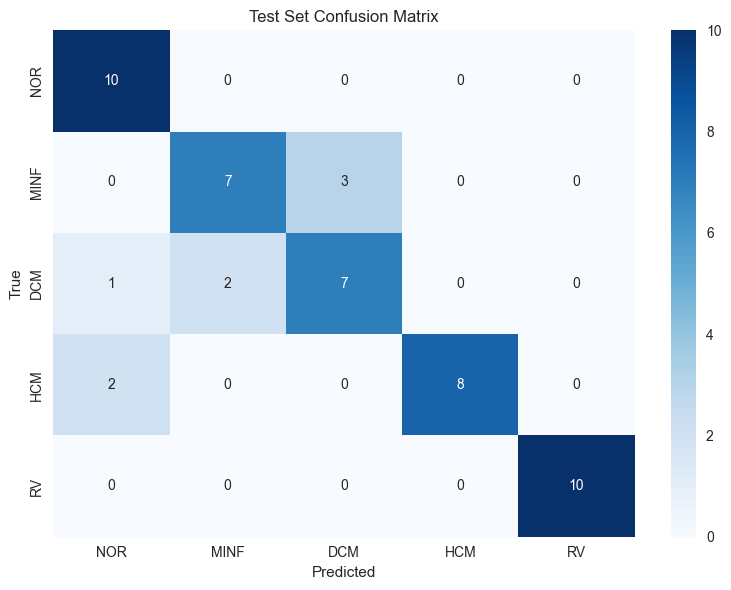


✅ Predictions saved to: /Volumes/Crucial X6/medical_ai_extra/processed/test_predictions.csv


In [8]:
# Preprocess test set (already done, but ensure consistency)
X_test_scaled = preprocess.transform(X_test)

# Predict
y_test_pred = final_model.predict(X_test_scaled)
y_test_proba = final_model.predict_proba(X_test_scaled)

# Metrics
test_acc = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average="macro")
test_cm = confusion_matrix(y_test, y_test_pred)

print("=" * 60)
print("TEST SET EVALUATION")
print("=" * 60)
print(f"Accuracy:  {test_acc:.4f}")
print(f"Macro F1:  {test_f1:.4f}")
print("\nConfusion Matrix:")
print(test_cm)
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

# Visualize confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    test_cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["NOR", "MINF", "DCM", "HCM", "RV"],
    yticklabels=["NOR", "MINF", "DCM", "HCM", "RV"],
    ax=ax,
)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Test Set Confusion Matrix")
plt.tight_layout()
plt.show()

# Save predictions - handle different PatientID column names
patient_id_col = None
for col in ["PatientID", "patient_id", "PatientID"]:
    if col in test_df.columns:
        patient_id_col = col
        break

if patient_id_col is None:
    # If no PatientID column, use index
    patient_ids = test_df.index.values
else:
    patient_ids = test_df[patient_id_col].values

predictions_df = pd.DataFrame(
    {
        "PatientID": patient_ids,
        "True_Label": y_test,
        "Predicted_Label": y_test_pred,
        "Predicted_Probability": [
            proba[y_test_pred[i]] for i, proba in enumerate(y_test_proba)
        ],
    }
)
predictions_df.to_csv(PROCESSED_DIR / "test_predictions.csv", index=False)
print(f"\n✅ Predictions saved to: {PROCESSED_DIR / 'test_predictions.csv'}")



## 8️⃣ Feature Importance / Explainability



Analyzing feature importance for: Logistic Regression
Number of features: 88


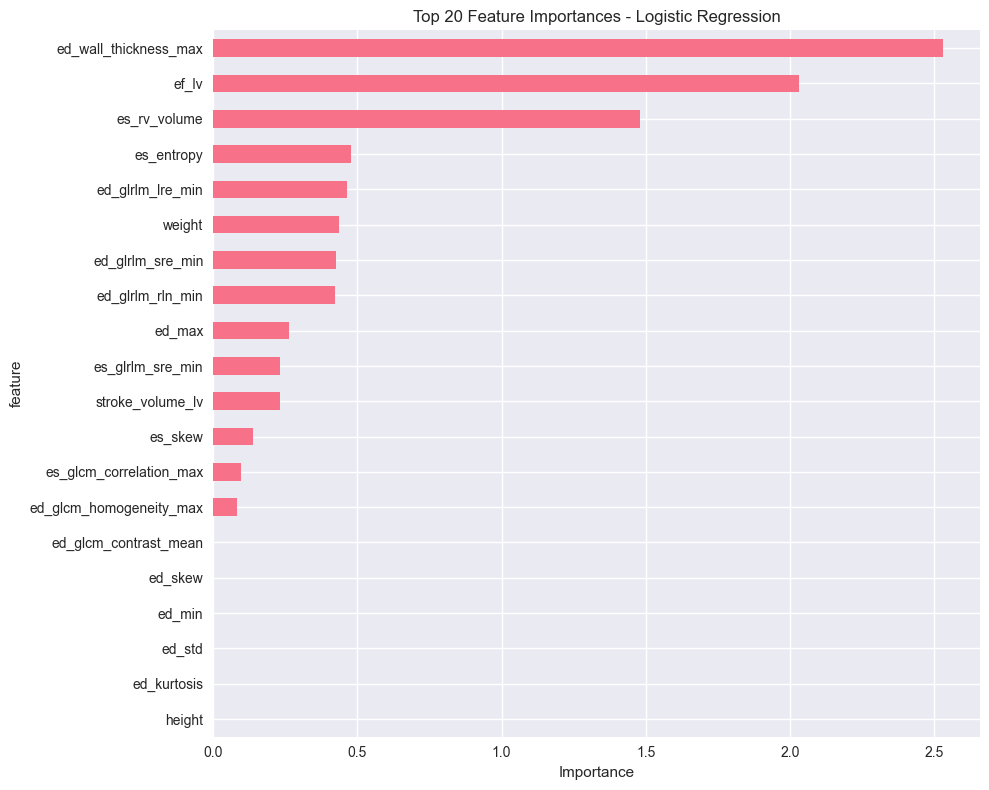


Top 20 Most Important Features:


,feature,importance
44,ed_wall_thickness_max,2.533068
87,ef_lv,2.033421
81,es_rv_volume,1.479465
52,es_entropy,0.476528
31,ed_glrlm_lre_min,0.463134
1,weight,0.436835
28,ed_glrlm_sre_min,0.425554
37,ed_glrlm_rln_min,0.423520
8,ed_max,0.261252
69,es_glrlm_sre_min,0.230555


In [9]:
# Get feature names (handle PCA case)
if USE_PCA and hasattr(preprocess.named_steps["pca"], "components_"):
    feature_names = [f"PC_{i+1}" for i in range(preprocess.named_steps["pca"].n_components_)]
else:
    feature_names = FEATURES

print(f"Analyzing feature importance for: {best_model_name}")
print(f"Number of features: {len(feature_names)}")

# Extract feature importance based on model type
if hasattr(final_model, "feature_importances_"):
    # Random Forest or XGBoost
    importances = final_model.feature_importances_
    importance_df = pd.DataFrame(
        {"feature": feature_names, "importance": importances}
    ).sort_values("importance", ascending=False)

elif hasattr(final_model, "coef_"):
    # Logistic Regression
    importances = np.abs(final_model.coef_[0])
    importance_df = pd.DataFrame(
        {"feature": feature_names, "importance": importances}
    ).sort_values("importance", ascending=False)

else:
    # SVM - use permutation importance or SHAP
    print("SVM model detected. Computing permutation importance...")
    from sklearn.inspection import permutation_importance

    perm_importance = permutation_importance(
        final_model, X_test_scaled[:50], y_test[:50], n_repeats=10, random_state=RANDOM_SEED
    )
    importances = perm_importance.importances_mean
    importance_df = pd.DataFrame(
        {"feature": feature_names, "importance": importances}
    ).sort_values("importance", ascending=False)

# Plot top 20 features
top_features = importance_df.head(20)

fig, ax = plt.subplots(figsize=(10, 8))
top_features.plot(kind="barh", x="feature", y="importance", ax=ax, legend=False)
ax.set_xlabel("Importance")
ax.set_title(f"Top 20 Feature Importances - {best_model_name}")
ax.invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 20 Most Important Features:")
display(top_features)



## 9️⃣ Save Pipeline + Model



In [ ]:
# Save directory
SAVE_DIR = Path.cwd()
if not EXTERNAL_PROCESSED.exists():
    SAVE_DIR = PROCESSED_DIR

# Save preprocessing pipeline
preprocess_path = SAVE_DIR / "preprocessing.pkl"
joblib.dump(preprocess, preprocess_path)
print(f"✅ Preprocessing pipeline saved: {preprocess_path}")

# Save best model
best_model_path = SAVE_DIR / "best_model.pkl"
joblib.dump(final_model, best_model_path)
print(f"✅ Best model saved: {best_model_path}")

# Create full pipeline (preprocessing + model)
full_pipeline = Pipeline([("preprocess", preprocess), ("classifier", final_model)])
full_pipeline_path = SAVE_DIR / "full_pipeline.pkl"
joblib.dump(full_pipeline, full_pipeline_path)
print(f"✅ Full pipeline saved: {full_pipeline_path}")

# Save model metadata
metadata = {
    "model_name": best_model_name,
    "best_params": tuned_models[best_model_name]["params"] if best_model_name in tuned_models else {},
    "test_accuracy": float(test_acc),
    "test_f1": float(test_f1),
    "feature_names": feature_names,
    "num_features": len(feature_names),
}

import json
metadata_path = SAVE_DIR / "model_metadata.json"
with open(metadata_path, "w") as f:
    json.dump(metadata, f, indent=2)
print(f"✅ Model metadata saved: {metadata_path}")

print("\n" + "=" * 60)
print("PIPELINE COMPLETE!")
print("=" * 60)
print(f"Final Test Accuracy: {test_acc:.4f}")
print(f"Final Test Macro F1: {test_f1:.4f}")
print(f"\nAll models saved to: {SAVE_DIR}")

